In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
# Ensure it's parsed as datetime first
sp500.index = pd.to_datetime(sp500.index, utc=True)  # Forcefully makes it tz-aware

# Then remove the timezone
sp500.index = sp500.index.tz_convert(None)

# Filter data from 13 June 2016 to 9 June 2021
sp500 = sp500.loc["2014-06-13":"2025-06-09"].copy()


In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-13 04:00:00,1930.800049,1937.300049,1927.689941,1936.160034,2598230000,0.0,0.0
2014-06-16 04:00:00,1934.839966,1941.150024,1930.910034,1937.780029,2926130000,0.0,0.0
2014-06-17 04:00:00,1937.150024,1943.689941,1933.550049,1941.989990,2971260000,0.0,0.0
2014-06-18 04:00:00,1942.729980,1957.739990,1939.290039,1956.979980,3065220000,0.0,0.0
2014-06-19 04:00:00,1957.500000,1959.869995,1952.260010,1959.479980,2952150000,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-03 04:00:00,5938.560059,5981.350098,5929.000000,5970.370117,5026680000,0.0,0.0
2025-06-04 04:00:00,5978.939941,5990.479980,5966.109863,5970.810059,4767050000,0.0,0.0
2025-06-05 04:00:00,5985.669922,5999.700195,5921.200195,5939.299805,5091850000,0.0,0.0


In [6]:
sp500.shape

(2764, 7)

In [7]:
# Apply standard single exponential smoothing (SES) to the Close price
alpha = 0.3  # smoothing factor (between 0 and 1)

sp500["SES_Close"] = sp500["Close"].ewm(alpha=alpha, adjust=False).mean()

In [8]:
sp500["Tomorrow"] = sp500["SES_Close"].shift(-1)

num_days = 30
sp500['Target'] = (sp500['SES_Close'].shift(-num_days) > sp500['SES_Close']).astype(int)

In [9]:
horizons = [2, 5, 60, 250]
new_predictors = []

for horizon in horizons:
    # Simple Moving Average (SMA)
    rolling_averages = sp500.rolling(horizon).mean()
    
    # Close Ratio: Today’s close / rolling average close
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["SES_Close"] / rolling_averages["SES_Close"]
    
    # Trend: Count of "up" days in past horizon
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    # Rolling Mean of Close
    ma_column = f"Rolling_Mean_{horizon}"
    sp500[ma_column] = rolling_averages["SES_Close"]

    # Exponential Moving Average of Close
    ema_column = f"EMA_{horizon}"
    sp500[ema_column] = sp500["SES_Close"].ewm(span=horizon, adjust=False).mean()

    # Add all to feature list
    new_predictors += [ratio_column, trend_column, ma_column, ema_column]
# Shift all predictors by 1 to prevent data leakage
sp500[new_predictors] = sp500[new_predictors].shift(1)
# Drop any rows with missing values in predictors or target
sp500 = sp500.dropna(subset=new_predictors + ['Target'])


In [10]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Rolling_Mean_2',
 'EMA_2',
 'Close_Ratio_5',
 'Trend_5',
 'Rolling_Mean_5',
 'EMA_5',
 'Close_Ratio_60',
 'Trend_60',
 'Rolling_Mean_60',
 'EMA_60',
 'Close_Ratio_250',
 'Trend_250',
 'Rolling_Mean_250',
 'EMA_250']

In [11]:
from xgboost import XGBClassifier

In [12]:
from sklearn.metrics import accuracy_score
import pandas as pd

# XGBoost prediction function
def predict_xgb(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


In [13]:
# XGBoost backtesting function
def backtest_xgb(data, model, predictors, start=500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_xgb(train, test, predictors, model)
        acc = accuracy_score(predictions["Target"], predictions["Predictions"])
        print(f"Backtest segment starting at {i}: Accuracy = {acc:.4f}")
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
from xgboost import XGBClassifier

In [15]:
# Initialize XGBoost model with tuned or default parameters
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.3,
    gamma=5,
    subsample=1.0,
    colsample_bytree=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=1
)

In [16]:


# Run backtest
results_xgb = backtest_xgb(sp500, xgb_model, new_predictors)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8840
Backtest segment starting at 750: Accuracy = 0.8960
Backtest segment starting at 1000: Accuracy = 0.9560
Backtest segment starting at 1250: Accuracy = 0.9400
Backtest segment starting at 1500: Accuracy = 0.9000
Backtest segment starting at 1750: Accuracy = 0.9400
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9360
Backtest segment starting at 2500: Accuracy = 1.0000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
precision_score(results_xgb["Target"], results_xgb["Predictions"]), accuracy_score(results_xgb["Target"], results_xgb["Predictions"])

(0.9308624376336422, 0.9279682066567313)

In [18]:
### --- Garman-Klass Volatility ---
sp500["Garman_Klass"] = (
    0.5 * (np.log(sp500["High"] / sp500["Low"]) ** 2)
    - (2 * np.log(2) - 1) * (np.log(sp500["SES_Close"] / sp500["Open"]) ** 2)
)
sp500["Garman_Klass"] = sp500["Garman_Klass"].shift(1)
new_predictors.append("Garman_Klass")

### --- RSI (Relative Strength Index) ---
delta = sp500["SES_Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
sp500["RSI"] = 100 - (100 / (1 + rs))
sp500["RSI"] = sp500["RSI"].shift(1)
new_predictors.append("RSI")

### --- MACD and MACD Diff ---
ema_12 = sp500["SES_Close"].ewm(span=12, adjust=False).mean()
ema_26 = sp500["SES_Close"].ewm(span=26, adjust=False).mean()
sp500["MACD"] = ema_12 - ema_26
sp500["Signal_Line"] = sp500["MACD"].ewm(span=9, adjust=False).mean()
sp500["MACD_Diff"] = (sp500["MACD"] - sp500["Signal_Line"]).shift(1)
new_predictors.append("MACD_Diff")

### --- ATR (Average True Range) ---
high_low = sp500["High"] - sp500["Low"]
high_close = np.abs(sp500["High"] - sp500["SES_Close"].shift(1))
low_close = np.abs(sp500["Low"] - sp500["SES_Close"].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
sp500["ATR"] = true_range.rolling(14).mean().shift(1)
new_predictors.append("ATR")

### --- Bollinger Band Width ---
rolling_mean = sp500["SES_Close"].rolling(window=20).mean()
rolling_std = sp500["SES_Close"].rolling(window=20).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
sp500["Boll_Width"] = ((upper_band - lower_band) / rolling_mean).shift(1)
new_predictors.append("Boll_Width")

### --- Dollar Volume ---
sp500["Dollar_Volume"] = (sp500["SES_Close"] * sp500["Volume"]).shift(1)
new_predictors.append("Dollar_Volume")

/var/folders/1h/1px02wgx233fjvxxzjdt1d900000gn/T/ipykernel_53581/1989604891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Garman_Klass"] = (
/var/folders/1h/1px02wgx233fjvxxzjdt1d900000gn/T/ipykernel_53581/1989604891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Garman_Klass"] = sp500["Garman_Klass"].shift(1)
/var/folders/1h/1px02wgx233fjvxxzjdt1d900000gn/T/ipykernel_53581/1989604891.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [19]:
# Drop rows with missing values before modeling
sp500 = sp500.dropna(subset=new_predictors + ['Target'])


In [20]:
results_xgb = backtest_xgb(sp500, xgb_model, new_predictors)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8920
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.7640
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8840


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9000
Backtest segment starting at 2250: Accuracy = 0.9300


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
precision_score(results_xgb["Target"], results_xgb["Predictions"]), accuracy_score(results_xgb["Target"], results_xgb["Predictions"])

(0.9420401854714064, 0.904666332162569)

In [22]:
# Step 1: Create feature mapping from XGBoost internal names to your actual column names
feature_map = {f"f{i}": name for i, name in enumerate(new_predictors)}

# Step 2: Get raw importances from the model using 'gain' (recommended)
raw_importances = xgb_model.get_booster().get_score(importance_type='gain')

# Step 3: Map and convert to pandas Series
importances = pd.Series({feature_map.get(k, k): v for k, v in raw_importances.items()})
importances = importances.sort_values(ascending=False)

# Step 4: Print top features
print("📌 Top Important Features (by gain):")
print(importances.head(15))


📌 Top Important Features (by gain):
Trend_2            289.508911
Trend_5            134.494080
MACD_Diff           22.423216
Rolling_Mean_2      14.399506
EMA_5               14.115679
EMA_250             10.643801
Close_Ratio_5       10.509229
EMA_60              10.247513
Close_Ratio_2        9.651188
Rolling_Mean_5       9.441874
Close_Ratio_60       8.750028
Close_Ratio_250      8.409908
Boll_Width           8.043437
Trend_60             7.624675
Trend_250            7.620126
dtype: float64


In [23]:
new_features = importances.head(10)

In [24]:
new_features = new_features.index.tolist()

In [25]:
new_features

['Trend_2',
 'Trend_5',
 'MACD_Diff',
 'Rolling_Mean_2',
 'EMA_5',
 'EMA_250',
 'Close_Ratio_5',
 'EMA_60',
 'Close_Ratio_2',
 'Rolling_Mean_5']

In [26]:
results_xgb = backtest_xgb(sp500, xgb_model, new_features)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.8920
Backtest segment starting at 750: Accuracy = 0.9240
Backtest segment starting at 1000: Accuracy = 0.7280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9480
Backtest segment starting at 1500: Accuracy = 0.7960
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383


In [27]:
precision_score(results_xgb["Target"], results_xgb["Predictions"]), accuracy_score(results_xgb["Target"], results_xgb["Predictions"])

(0.9161585365853658, 0.8785750125439037)

In [28]:
from itertools import product
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score
import pandas as pd

# Define your parameter grid
param_grid = {
    'n_estimators': [100, 250, 350],
    'max_depth': [4, 5, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [5]
}

results = []

# Iterate over all combinations
for n, d, lr, ss, cs, g in product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['gamma']
):
    print(f"\n🔍 Testing: n_estimators={n}, max_depth={d}, learning_rate={lr}, subsample={ss}, colsample_bytree={cs}, gamma={g}")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=n,
        max_depth=d,
        learning_rate=lr,
        subsample=ss,
        colsample_bytree=cs,
        gamma=g,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=1
    )

    predictions = backtest_xgb(sp500, xgb_model, new_features)
    precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])

    results.append({
        'n_estimators': n,
        'max_depth': d,
        'learning_rate': lr,
        'subsample': ss,
        'colsample_bytree': cs,
        'gamma': g,
        'precision': precision,
        'accuracy': accuracy
    })

# Compile results
results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print("\n📊 Top Performing Configs:")
print(results_df.head(10))


🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9440


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9240


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9280
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9280
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9600
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.8840
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8960
Backtest segment starting at 750: Accuracy = 0.9080
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8040


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8440
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9040
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9520
Backtest segment starting at 1500: Accuracy = 0.9200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8440
Backtest segment starting at 750: Accuracy = 0.9040
Backtest segment starting at 1000: Accuracy = 0.7680
Backtest segment starting at 1250: Accuracy = 0.9520
Backtest segment starting at 1500: Accuracy = 0.8000
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9040
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.8680
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8400
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.8240
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9440


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9240
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9600
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8960
Backtest segment starting at 750: Accuracy = 0.9040
Backtest segment starting at 1000: Accuracy = 0.7560
Backtest segment starting at 1250: Accuracy = 0.9480
Backtest segment starting at 1500: Accuracy = 0.8680
Backtest segment starting at 1750: Accuracy = 0.9440
Backtest segment starting at 2000: Accuracy = 0.7040


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9040
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9240
Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7280
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8440
Backtest segment starting at 750: Accuracy = 0.8960
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.7600
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9120
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8720
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8240
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9440
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9240
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9280
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9600
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8760
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8280
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8960
Backtest segment starting at 750: Accuracy = 0.9040
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9400
Backtest segment starting at 1500: Accuracy = 0.7640
Backtest segment starting at 1750: Accuracy = 0.9200
Backtest segment starting at 2000: Accuracy = 0.8800


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9040
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.8680
Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7160
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9080
Backtest segment starting at 1000: Accuracy = 0.7320
Backtest segment starting at 1250: Accuracy = 0.9520
Backtest segment starting at 1500: Accuracy = 0.7240
Backtest segment starting at 1750: Accuracy = 0.9400
Backtest segment starting at 2000: Accuracy = 0.6920
Backtest segment starting at 2250: Accuracy = 0.8930

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8720
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=100, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8400
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.7600
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9440


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9440
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9120
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9400
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8960


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9320
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8240
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.8760
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9240
Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9280
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.7320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8440
Backtest segment starting at 750: Accuracy = 0.9040
Backtest segment starting at 1000: Accuracy = 0.7680
Backtest segment starting at 1250: Accuracy = 0.5040
Backtest segment starting at 1500: Accuracy = 0.8000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8960
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8720
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8560
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9440
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9440
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9120


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9120
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9440
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8960
Backtest segment starting at 750: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9360
Backtest segment starting at 1250: Accuracy = 0.9520
Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9120


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.6920
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.8760
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9240
Backtest segment starting at 1750: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9400
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7200
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9520
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8440
Backtest segment starting at 750: Accuracy = 0.9080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.5800
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.7760
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.8400
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9400
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9440
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9280
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8840


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8960
Backtest segment starting at 750: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.8760
Backtest segment starting at 1500: Accuracy = 0.7600
Backtest segment starting at 1750: Accuracy = 0.9400


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.7760
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.8760
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.8400
Backtest segment starting at 1750: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9520
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9080
Backtest segment starting at 1000: Accuracy = 0.5720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9520
Backtest segment starting at 1500: Accuracy = 0.7200
Backtest segment starting at 1750: Accuracy = 0.9440
Backtest segment starting at 2000: Accuracy = 0.7000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.8971

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=250, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8400
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.7040


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9400


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9600
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9400
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 750: Accuracy = 0.9240
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560
Backtest segment starting at 1500: Accuracy = 0.8200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8400
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.8400
Backtest segment starting at 750: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9160
Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9259

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9640
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.8440
Backtest segment starting at 750: Accuracy = 0.8720
Backtest segment starting at 1000: Accuracy = 0.6000
Backtest segment starting at 1250: Accuracy = 0.5960
Backtest segment starting at 1500: Accuracy = 0.8000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.7240
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2000: Accuracy = 0.8720
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=4, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8360
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 500: Accuracy = 0.9400
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9480
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9200
Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9080
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9120
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9480
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9360
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.8760
Backtest segment starting at 750: Accuracy = 0.9160
Backtest segment starting at 1000: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9440
Backtest segment starting at 1500: Accuracy = 0.8280
Backtest segment starting at 1750: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.7640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.8400


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9600
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.9240


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9360
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9640
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7240
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9040
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8440


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9080
Backtest segment starting at 1000: Accuracy = 0.5800
Backtest segment starting at 1250: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.7760
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8440


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=5, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8160
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.6, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9400
Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9480


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9200


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9520
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080
Backtest segment starting at 750: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.8480
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9600
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9080


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9640
Backtest segment starting at 1500: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.6, colsample_bytree=1.0, gamma=5
Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9640


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.9320
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.9640
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9680


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.9360
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9480
Backtest segment starting at 2250: Accuracy = 0.9300

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9160
Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.8760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.7760
Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.8280


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.8400
Backtest segment starting at 750: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9760
Backtest segment starting at 1250: Accuracy = 0.9680
Backtest segment starting at 1500: Accuracy = 0.8160


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9480
Backtest segment starting at 2000: Accuracy = 0.9440
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.6, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9120
Backtest segment starting at 750: Accuracy = 0.9640
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.7120
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.9040
Backtest segment starting at 2250: Accuracy = 0.9342

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.6, gamma=5
Backtest segment starting at 500: Accuracy = 0.9000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9080
Backtest segment starting at 1000: Accuracy = 0.7320
Backtest segment starting at 1250: Accuracy = 0.6760


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.7200
Backtest segment starting at 1750: Accuracy = 0.9320
Backtest segment starting at 2000: Accuracy = 0.7000


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.8930

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=0.8, gamma=5
Backtest segment starting at 500: Accuracy = 0.9160
Backtest segment starting at 750: Accuracy = 0.9560


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.8760
Backtest segment starting at 2250: Accuracy = 0.9383

🔍 Testing: n_estimators=350, max_depth=8, learning_rate=0.3, subsample=0.8, colsample_bytree=1.0, gamma=5


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 500: Accuracy = 0.9320
Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1250: Accuracy = 0.9600
Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2000: Accuracy = 0.7360
Backtest segment starting at 2250: Accuracy = 0.9300

📊 Top Performing Configs:
     n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
94            250          8           0.01        0.8               0.8   
76            250          5           0.01        0.8               0.8   
0             100          4           0.01        0.6               0.6   
18            100          5           0.01        0.6               0.6   
110           350          4           0.01        0.6               1.0   
127           350          5           0.01        0.6               0.8   
128           350          5           0.01        0.6               1.0   
36            100          8           0.01        0.6               0.6   
145           350          8           0.01        0.6               0.8   
146           350          8           0.01        0.6               1.0   

     gamma  precision  accurac

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:
results_df

,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,precision,accuracy
94,250,8,0.01,0.8,0.8,5,0.966114,0.951831
76,250,5,0.01,0.8,0.8,5,0.966114,0.951831
0,100,4,0.01,0.6,0.6,5,0.963991,0.951330
18,100,5,0.01,0.6,0.6,5,0.963991,0.951330
110,350,4,0.01,0.6,1.0,5,0.966089,0.951330
...,...,...,...,...,...,...,...,...
51,100,8,0.30,0.8,0.6,5,0.885196,0.842449
69,250,4,0.30,0.8,0.6,5,0.898785,0.824887
105,250,8,0.30,0.8,0.6,5,0.883087,0.823884
159,350,8,0.30,0.8,0.6,5,0.877583,0.807326


In [30]:
import xgboost as xgb

# Get the best row (top-performing configuration)
best_params = results_df.iloc[0]

# Extract each parameter
best_n = int(best_params['n_estimators'])
best_d = int(best_params['max_depth'])
best_lr = float(best_params['learning_rate'])
best_ss = float(best_params['subsample'])
best_cs = float(best_params['colsample_bytree'])
best_g = float(best_params['gamma'])

# Build the best XGBoost model
best_xgb_model = xgb.XGBClassifier(
    n_estimators=best_n,
    max_depth=best_d,
    learning_rate=best_lr,
    subsample=best_ss,
    colsample_bytree=best_cs,
    gamma=best_g,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=1
)


In [31]:
def predict_xgb(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    
    # Get probability of class 1
    probs = model.predict_proba(test[predictors])[:, 1]
    saved_probs = pd.Series(probs, index=test.index, name="Probabilities")
    
    # Apply threshold
    preds = (saved_probs >= 0.6).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Combine everything into a single DataFrame
    combined = pd.concat([test["Target"], preds, saved_probs], axis=1)
    
    return combined

In [32]:
predictions = backtest_xgb(sp500, xgb_model, new_features)

Backtest segment starting at 500: Accuracy = 0.9320


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 750: Accuracy = 0.9560
Backtest segment starting at 1000: Accuracy = 0.9720
Backtest segment starting at 1250: Accuracy = 0.9600


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 1500: Accuracy = 0.8240
Backtest segment starting at 1750: Accuracy = 0.9520
Backtest segment starting at 2000: Accuracy = 0.7360


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:42:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Backtest segment starting at 2250: Accuracy = 0.9300


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = predictions["Target"]
y_pred = predictions["Predictions"]

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

# Print all
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")

Accuracy:    0.9077
Precision:   0.9376
Recall:      0.9235
Specificity: 0.8756
F1 Score:    0.9305


In [34]:
predictions

,Target,Predictions,Probabilities
Date,,,
2017-07-06 04:00:00,1,1,0.984312
2017-07-07 04:00:00,1,1,0.984312
2017-07-10 04:00:00,1,1,0.984312
2017-07-11 04:00:00,1,1,0.984312
2017-07-12 04:00:00,1,1,0.984312
...,...,...,...
2025-06-03 04:00:00,0,0,0.033520
2025-06-04 04:00:00,0,0,0.033520
2025-06-05 04:00:00,0,0,0.033520


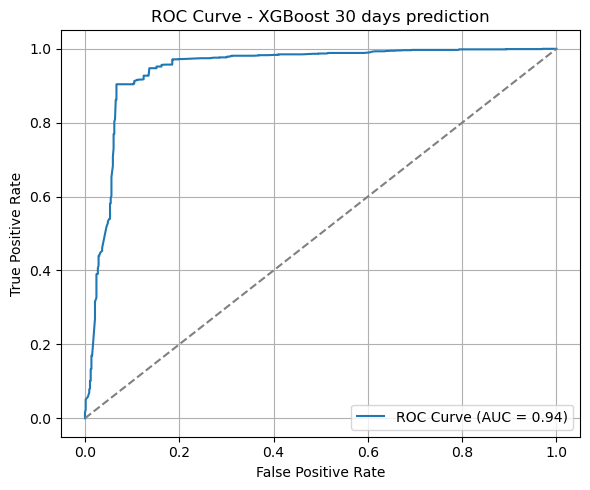

In [35]:
# Compute ROC curve and AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_scores = predictions["Probabilities"]
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - XGBoost {num_days} days prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## This is the END

In [80]:
num_days

30

In [ ]:
# n_estimators	max_depth	learning_rate	subsample	colsample_bytree	gamma	precision	accuracy
# Num_days1 ==> 100	4	0.01	0.6	1.0	5	0.736342	0.659809, 0.617 (before tuning)
# Num_days5 ==> 100	4	0.01	0.6	0.8	5	0.866203	0.821877, 0.7626 (before tuning)
# Num_days10 ==> 250	4	0.01	0.6	0.8	5	0.931852	0.903161, 0.8354
# Num_days20 ==>  350	5	0.01	0.8	1.0	 5 
# Num_days30 ==> 250	8	0.01	0.8	0.8	5
# Num_days40 ==> 100	5	0.01	0.6	1.0	5	

In [82]:
# XGBoost 10 days prediction

# Accuracy:    0.8455
# Precision:   0.9161
# Recall:      0.8514
# Specificity: 0.8328
# F1 Score:    0.8825




In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
param_grid = {
    'n_estimators': [100, 250, 350],
    'max_depth': [4, 8, 16],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='precision', cv=tscv)



In [ ]:
data = sp500.copy(deep=True)

In [ ]:
    # 1. Select features and target
    X = data[new_features].copy()
    y = data["Target"].copy()

    # Drop missing values (in case of rolling features)
    df = pd.concat([X, y], axis=1).dropna()
    X = df[new_features]
    y = df["Target"]

    # 2. Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Time-aware train/test split (80/20)
    split_point = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
grid_search.fit(X_train, y_train)


In [ ]:
print("Best parameters:")
print(grid_search.best_params_)

print("Best precision score:")
print(grid_search.best_score_)


In [ ]:
threshold = 0.5

In [ ]:
best_model = grid_search.best_estimator_

# Predict with custom threshold
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > threshold).astype(int)

# Evaluate
print("Precision:", precision_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall:   ", recall_score(y_test, y_pred))
print("f1 score:  ", f1_score(y_test, y_pred))


In [ ]:
y_train.value_counts()

In [ ]:
num_days

In [ ]:
num_of days, precision, accuracy, recall, f1_score, before tuning accuracy, 
num_days5, 0.88095, 0.803030303030303, 0.8222222222222222, 0.8505747126436781, 0.63, {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 350, 'subsample': 0.6}
num_days10, 0.92, 0.409, 0.166, 0.2822, 0.353,{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.8} 
num_days20, 0.945, 0.8939, 0.9150, 0.930, 0.368, {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 350, 'subsample': 0.6}
num_days30, 0.97, 0.949, 0.96, 0.96, 0.326, {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.6}
num_days40, 0.9736, 0.9696, 0.986, 0.980

In [ ]:
# Define the data
model_accuracy = {
    "LSTM": [0.63, 0.73, 0.85, 0.88, 0.93, 0.91, 0.95],
    "RF": [0.65, 0.80, 0.88, 0.925, 0.9384, 0.9439],
    "XGBoost": [0.673, 0.803, 0.89, 0.8939, 0.949, 0.9696]
}

# Define prediction days
prediction_days = [1, 5, 10, 20, 30, 40]

# Adjust LSTM data to match the same number of points
lstm_days = [1, 5, 10, 20, 30, 40]
lstm_accuracy = model_accuracy["LSTM"][1:]  # remove the first '0.63' for alignment

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lstm_days, lstm_accuracy, marker='o', color='blue', label='LSTM')
plt.plot(prediction_days, model_accuracy["RF"], marker='o', color='green', label='Random Forest')
plt.plot(prediction_days, model_accuracy["XGBoost"], marker='o', color='red', label='XGBoost')

plt.title("Model Accuracy vs Prediction Horizon")
plt.xlabel("Days Ahead")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.xticks(prediction_days)
plt.ylim(0.3, 1.0)

plt.tight_layout()
plt.show()

## Check for linear Seperability

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Assuming you have your feature matrix `X` and label vector `y`
# X = your feature dataframe
# y = your target labels (0 or 1)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split based on classes
class0 = X_pca[y == 0]
class1 = X_pca[y == 1]

# Compute convex hulls
hull0 = ConvexHull(class0)
hull1 = ConvexHull(class1)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(class0[:, 0], class0[:, 1], color='red', label='Class 0')
plt.scatter(class1[:, 0], class1[:, 1], color='blue', label='Class 1')

# Draw convex hull for class 0
for simplex in hull0.simplices:
    plt.plot(class0[simplex, 0], class0[simplex, 1], 'r-')

# Draw convex hull for class 1
for simplex in hull1.simplices:
    plt.plot(class1[simplex, 0], class1[simplex, 1], 'b-')

plt.title("Convex Hulls of Classes (PCA-Reduced Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

	•	The convex hulls of Class 0 and Class 1 intersect, especially in the middle region.
	•	Many red points lie within the blue convex hull and vice versa, meaning the points from different classes are mixed.
	•	You cannot draw a straight line that completely separates all red points from blue ones in this 2D projection.

There is no clear linear boundary that can separate the two classes based on the features — at least after PCA transformation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Assuming you already have X (features) and y (labels)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Separate by class
class0 = X_pca[y == 0]
class1 = X_pca[y == 1]

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(class0[:, 0], class0[:, 1], class0[:, 2], color='red', label='Class 0', alpha=0.6)
ax.scatter(class1[:, 0], class1[:, 1], class1[:, 2], color='blue', label='Class 1', alpha=0.6)

ax.set_title("3D PCA Projection of Feature Space")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()